In [1]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pprint import pprint
import psycopg2
from psycopg2 import sql

#Spark imports
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
import os
import sys


# Start a SparkSession
import findspark
findspark.init()


%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=62ba65c8b198a8ad4c99c52b7fd359e59ef7976a181a6e3583c64a550648bf2e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
# Import packages
from pyspark.sql import SparkSession
# Import the time module so we can time our queries.
import time
# Create a SparkSession
spark = SparkSession.builder \
    .appName("SqlSpark") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [22]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
url = "https://aws-project-4.s3.ca-central-1.amazonaws.com/encoded_df.csv"
spark.sparkContext.addFile(url)
encoded_df = spark.read.csv(SparkFiles.get("encoded_df.csv"), sep=",", header=True)

# Display the DataFrame
encoded_df.show(5)

+----------+---------+------------+---+---+-----------+----------+--------+--------------+-------+-------+-------------------+-----------------------+-----------------------+--------------+------------+-----------------------+------+------------------+-------------+-------------------------------+-------------------+-------------+----------+-----------------+-----------------+------------------+-----+-----+------------+------------+--------------+
|Patient ID|  Country|     Capital|Age|Sex|Cholesterol|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|Income|               BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|    Continent|Hemisphere|Heart Attack Risk|Systolic Pressure|Diastolic Pressure|  lat| long|Diet_Average|Diet_Healthy|Diet_Unhealthy|
+----------+---------+------------+---+---+-----------+----------+--------+--------------+------

In [23]:
encoded_df = encoded_df.toPandas()

In [24]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Patient ID                       8763 non-null   object
 1   Country                          8763 non-null   object
 2   Capital                          8763 non-null   object
 3   Age                              8763 non-null   object
 4   Sex                              8763 non-null   object
 5   Cholesterol                      8763 non-null   object
 6   Heart Rate                       8763 non-null   object
 7   Diabetes                         8763 non-null   object
 8   Family History                   8763 non-null   object
 9   Smoking                          8763 non-null   object
 10  Obesity                          8763 non-null   object
 11  Alcohol Consumption              8763 non-null   object
 12  Exercise Hours Per Week          8

In [25]:
# Convert columns to the desired data types
encoded_df['Age'] = encoded_df['Age'].astype(int)
encoded_df['Cholesterol'] = encoded_df['Cholesterol'].astype(int)
encoded_df['Heart Rate'] = encoded_df['Heart Rate'].astype(int)
encoded_df['Diabetes'] = encoded_df['Diabetes'].astype(int)
encoded_df['Family History'] = encoded_df['Family History'].astype(int)
encoded_df['Smoking'] = encoded_df['Smoking'].astype(int)
encoded_df['Obesity'] = encoded_df['Obesity'].astype(int)
encoded_df['Alcohol Consumption'] = encoded_df['Alcohol Consumption'].astype(int)
encoded_df['Exercise Hours Per Week'] = encoded_df['Exercise Hours Per Week'].astype(float)
encoded_df['Previous Heart Problems'] = encoded_df['Previous Heart Problems'].astype(int)
encoded_df['Medication Use'] = encoded_df['Medication Use'].astype(int)
encoded_df['Stress Level'] = encoded_df['Stress Level'].astype(int)
encoded_df['Sedentary Hours Per Day'] = encoded_df['Sedentary Hours Per Day'].astype(float)
encoded_df['Income'] = encoded_df['Income'].astype(int)
encoded_df['BMI'] = encoded_df['BMI'].astype(float)
encoded_df['Triglycerides'] = encoded_df['Triglycerides'].astype(int)
encoded_df['Physical Activity Days Per Week'] = encoded_df['Physical Activity Days Per Week'].astype(int)
encoded_df['Sleep Hours Per Day'] = encoded_df['Sleep Hours Per Day'].astype(int)
encoded_df['Systolic Pressure'] = encoded_df['Systolic Pressure'].astype(int)
encoded_df['Diastolic Pressure'] = encoded_df['Diastolic Pressure'].astype(int)
encoded_df['lat'] = encoded_df['lat'].astype(float)
encoded_df['long'] = encoded_df['long'].astype(float)
encoded_df['Diet_Average'] = encoded_df['Diet_Average'].astype(int)
encoded_df['Diet_Healthy'] = encoded_df['Diet_Healthy'].astype(int)
encoded_df['Diet_Unhealthy'] = encoded_df['Diet_Unhealthy'].astype(int)

# Print the data types of all columns
encoded_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Country                          8763 non-null   object 
 2   Capital                          8763 non-null   object 
 3   Age                              8763 non-null   int64  
 4   Sex                              8763 non-null   object 
 5   Cholesterol                      8763 non-null   int64  
 6   Heart Rate                       8763 non-null   int64  
 7   Diabetes                         8763 non-null   int64  
 8   Family History                   8763 non-null   int64  
 9   Smoking                          8763 non-null   int64  
 10  Obesity                          8763 non-null   int64  
 11  Alcohol Consumption              8763 non-null   int64  
 12  Exercise Hours Per W

# Separate features and target variable

In [54]:
# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']

# Printing the columns in X
print(X.columns)


Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems',
       'Medication Use', 'BMI', 'Triglycerides', 'Systolic Pressure',
       'Diastolic Pressure'],
      dtype='object')


# Split the data into training and testing sets

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [57]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [58]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [59]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

In [60]:
# Fit the model and use .ravel()on the "y_train" data.
rf_model = rf_model.fit(X_train_scaled, y_train)

In [61]:
# Making predictions using the testing data
rf_predictions = rf_model.predict(X_test_scaled)

In [62]:
print(f"Training Data Score: {rf_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rf_model.score(X_test_scaled, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.6252139189960069


In [63]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, rf_predictions)

In [64]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, rf_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1076,49
Actual 1,608,20


Accuracy Score : 0.6252139189960069
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.96      0.77      1125
           1       0.29      0.03      0.06       628

    accuracy                           0.63      1753
   macro avg       0.46      0.49      0.41      1753
weighted avg       0.51      0.63      0.51      1753



In [17]:
# Get the feature importance array
importances = rf_model.feature_importances_

# List the top 10 most important features
importances_top_10 = sorted(zip(importances, X.columns), reverse=True)[:10]
print("Top 10 most important features:")
pprint(importances_top_10)

Top 10 most important features:
[(0.13668777034555477, 'BMI'),
 (0.1330755039509209, 'Triglycerides'),
 (0.1296822901907914, 'Cholesterol'),
 (0.12061988933981975, 'Systolic Pressure'),
 (0.11680282141392462, 'Age'),
 (0.1149790413745522, 'Heart Rate'),
 (0.11117956690373326, 'Diastolic Pressure'),
 (0.020655081991957324, 'Medication Use'),
 (0.020547867738163843, 'Previous Heart Problems'),
 (0.019538792127817776, 'Alcohol Consumption')]


# KNN model

In [18]:
# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']
print(X.columns)

Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems',
       'Medication Use', 'BMI', 'Triglycerides', 'Systolic Pressure',
       'Diastolic Pressure'],
      dtype='object')


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [21]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [22]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
# Instantiate the model with k = 3 neighbors
knn_model = KNeighborsClassifier(n_neighbors=20)

# Train the model
knn_model.fit(X_train_scaled, y_train)
# Create predictions
knn_y_pred = knn_model.predict(X_test_scaled)

In [24]:
print(f"Training Data Score: {knn_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {knn_model.score(X_test_scaled, y_test)}")

Training Data Score: 0.6507845934379458
Testing Data Score: 0.6269252709640616


In [25]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, knn_y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, knn_y_pred)

In [26]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  knn_y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1066,59
Actual 1,595,33


Accuracy Score : 0.6269252709640616
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.95      0.77      1125
           1       0.36      0.05      0.09       628

    accuracy                           0.63      1753
   macro avg       0.50      0.50      0.43      1753
weighted avg       0.54      0.63      0.52      1753



# LogisticRegression

In [28]:
# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']
print(X.columns)

Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems',
       'Medication Use', 'BMI', 'Triglycerides', 'Systolic Pressure',
       'Diastolic Pressure'],
      dtype='object')


In [29]:
#balance labels y
balance_labels = y.value_counts()
balance_labels

0    5624
1    3139
Name: Heart Attack Risk, dtype: int64

There seems to be a bit of imbalance, with more instances of
class 0 compared to class 1. Depending on our model's sensitivity to class
imbalances, we may want to consider techniques like (1) oversampling,
(2) undersampling, or (3) using class weights during model training to handle this imbalance.

In [30]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape

(7010, 15)

7010: This is the number of samples or instances in your training set. Each row represents a separate observation or data point in your dataset.

26: This is the number of features or variables in your dataset. Each column in your dataset corresponds to a different feature or attribute that is used for training your machine learning model.

So, in summary, you have 7010 training samples, and each sample has 26 features. This information is crucial for understanding the dimensions of your training data, especially when you're working with machine learning models that require input of specific shapes.

In [31]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_model = LogisticRegression(solver="lbfgs",max_iter=20, random_state=1)

In [32]:
# Fit the model using training data
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [33]:
print(f"Training Data Score: {logistic_model.score(X_train, y_train)}")
print(f"Testing Data Score: {logistic_model.score(X_test, y_test)}")

Training Data Score: 0.6393723252496434
Testing Data Score: 0.6514546491728466


In [34]:
# Make a prediction using the testing data
lr_predictions = logistic_model.predict(X_test)
results = pd.DataFrame({"Prediction": lr_predictions, "Actual": y_test}).reset_index(drop = True)
results.head(10)

,Prediction,Actual
0,0,1
1,0,0
2,0,0
3,0,1
4,0,1
5,0,0
6,0,1
7,0,0
8,0,1
9,0,1


In [35]:
accuracy_score(y_test, lr_predictions)

0.6514546491728466

### Evaluation of the model’s performance by doing the following:

* Calculate the accuracy score of the model.

* Generate a confusion matrix.

* Print the classification report.

In [36]:
balanced_accuracy = accuracy_score(y_test, lr_predictions)
balanced_accuracy

0.6514546491728466

In [37]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, lr_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, lr_predictions)

In [38]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  lr_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1142,0
Actual 1,611,0


Accuracy Score : 0.6514546491728466
Classification Report
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1142
           1       0.00      0.00      0.00       611

    accuracy                           0.65      1753
   macro avg       0.33      0.50      0.39      1753
weighted avg       0.42      0.65      0.51      1753



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's break down what each of these means:

True Negative (TN): 18673 instances were correctly predicted as class 0 (negative class).

False Positive (FP): 86 instances were incorrectly predicted as class 1 (positive class) when they were actually class 0.

False Negative (FN): 32 instances were incorrectly predicted as class 0 when they were actually class 1.

True Positive (TP): 593 instances were correctly predicted as class 1.

Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. In your case:

Precision for class 0: 0.65 (65% of instances predicted as class 0 were actually class 0)
Precision for class 1: 0.00 (None of the instances predicted as class 1 were actually class 1)
Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to the all observations in actual class. In your case:

Recall for class 0: 1.00 (All instances of class 0 were correctly predicted)
Recall for class 1: 0.00 (None of the instances of class 1 were correctly predicted)
F1-Score: F1-Score is the weighted average of Precision and Recall. It is a balance between precision and recall. In your case:

F1-Score for class 0: 0.79 (Weighted average of precision and recall for class 0)
F1-Score for class 1: 0.00 (Weighted average of precision and recall for class 1)
Support: The number of actual occurrences of each class in the specified dataset. In your case:

Support for class 0: 1142 instances
Support for class 1: 611 instances
Accuracy: Overall accuracy of the model on the testing data. In your case: 0.65 (65%)

Macro Average: The average of precision, recall, and F1-Score for both classes, without considering class imbalance. In your case:

Macro Average Precision: 0.33
Macro Average Recall: 0.50
Macro Average F1-Score: 0.39
Weighted Average: The average of precision, recall, and F1-Score, weighted by the number of samples in each class. In your case:

Weighted Average Precision: 0.42
Weighted Average Recall: 0.65
Weighted Average F1-Score: 0.51
These metrics provide a more nuanced understanding of your model's performance for each class and overall. In this case, it seems that the model is performing well in predicting class 0 but struggling to predict class 1, as indicated by the low recall and F1-Score for class 1. Depending on the specific goals of your model, you may need to adjust the model or data preprocessing to improve its performance.

In [39]:
#Handling Imbalanced Data:

logistic_model = LogisticRegression(class_weight='balanced', random_state=1)

In [40]:
!pip install imbalanced-learn

In [41]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [42]:
# Instantiate a new logistic regression model
logistic_model_resampled = LogisticRegression(random_state=1)

# Fit the model with the resampled data
logistic_model_resampled.fit(X_resampled, y_resampled)

# Make predictions on the testing data
predictions_resampled = logistic_model_resampled.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
#Evaluate the performance
accuracy_resampled = accuracy_score(y_test, predictions_resampled)
classification_report_resampled = classification_report(y_test, predictions_resampled)
confusion_matrix_resampled = confusion_matrix(y_test, predictions_resampled)

print("Accuracy (Resampled):", accuracy_resampled)
print("Classification Report (Resampled):\n", classification_report_resampled)
print("Confusion Matrix (Resampled):\n", confusion_matrix_resampled)

Accuracy (Resampled): 0.5208214489446663
Classification Report (Resampled):
               precision    recall  f1-score   support

           0       0.64      0.59      0.62      1142
           1       0.34      0.38      0.36       611

    accuracy                           0.52      1753
   macro avg       0.49      0.49      0.49      1753
weighted avg       0.54      0.52      0.53      1753

Confusion Matrix (Resampled):
 [[678 464]
 [376 235]]


# GridSearchCV

In [44]:
# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']
print(X.columns)

Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems',
       'Medication Use', 'BMI', 'Triglycerides', 'Systolic Pressure',
       'Diastolic Pressure'],
      dtype='object')


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming you already have X and y defined

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating StandardScaler instance
scaler = MinMaxScaler()

# Fitting StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the pipeline including MinMaxScaler and KNeighborsClassifier
knn_pipe = Pipeline([
    ('mms', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

# Define the parameters grid for GridSearchCV
params = [{
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__leaf_size': [15, 20]
}]

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation
gs_knn = GridSearchCV(
    knn_pipe,
    param_grid=params,
    scoring='accuracy',
    cv=5
)

# Fit GridSearchCV on the training data
gs_knn.fit(X_train_scaled, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", gs_knn.best_params_)

# Find the score of the best model on the training data
print("Best Model Score on Training Data:", gs_knn.score(X_train_scaled, y_train))
print(f"Training Data Score: {gs_knn.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {gs_knn.score(X_test_scaled, y_test)}")

Best Parameters: {'knn__leaf_size': 15, 'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
Best Model Score on Training Data: 0.677318116975749
Training Data Score: 0.677318116975749
Testing Data Score: 0.5887050770108385


In [46]:
gs_knn_y_pred = gs_knn.predict(X_test_scaled)

In [47]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, gs_knn_y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, gs_knn_y_pred)

In [48]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  gs_knn_y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,919,206
Actual 1,515,113


Accuracy Score : 0.5887050770108385
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.82      0.72      1125
           1       0.35      0.18      0.24       628

    accuracy                           0.59      1753
   macro avg       0.50      0.50      0.48      1753
weighted avg       0.54      0.59      0.55      1753



# Grid Search with Logistic Regression

In [68]:
# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']
print(X.columns)

Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems',
       'Medication Use', 'BMI', 'Triglycerides', 'Systolic Pressure',
       'Diastolic Pressure'],
      dtype='object')


In [69]:
# Convert columns to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Normalize the numeric columns
X = (X - X.min()) / (X.max() - X.min())


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.6411802370995425


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

In [72]:
logreg2=LogisticRegression(C=1,penalty="l2")
logreg2.fit(X_train,y_train)
logreg2_prediction = logreg2.predict(X_test)
print(f"Training Data Score: {logreg2.score(X_train,y_train)}")
print(f"Testing Data Score: {logreg2.score(X_test,y_test)}")

Training Data Score: 0.6411803064884252
Testing Data Score: 0.6432103461392165


In [73]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, logreg2_prediction)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, logreg2_prediction)

In [75]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  logreg2_prediction))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1691,0
Actual 1,938,0


Accuracy Score : 0.6432103461392165
Classification Report
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1691
           1       0.00      0.00      0.00       938

    accuracy                           0.64      2629
   macro avg       0.32      0.50      0.39      2629
weighted avg       0.41      0.64      0.50      2629



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.1 MB/s eta 0:00:00


In [26]:
# Import our dependencies
import sklearn as skl
import tensorflow as tf

# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']

# Use sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [65]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras_tuner import HyperModel, RandomSearch

# Assuming X and y are your features and target variable respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert string labels to numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the target variable is in float format
y_train_float = y_train_encoded.astype(float)
y_test_float = y_test_encoded.astype(float)

# Define the hypermodel for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('first_units',
                                  min_value=32,
                                  max_value=512,
                                  step=32),
                    activation=hp.Choice('activation',
                                         values=['relu', 'tanh', 'sigmoid', 'softmax'])))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(units=hp.Int(f'units_{i}',
                                      min_value=4,
                                      max_value=512,
                                      step=32),
                        activation=hp.Choice('activation',
                                             values=['relu', 'tanh', 'sigmoid', 'softmax'])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='helloworld')

# Perform the hyperparameter search
tuner.search(X_train_scaled, y_train_float, epochs=20, validation_data=(X_test_scaled, y_test_float))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the training data
train_loss, train_accuracy = best_model.evaluate(X_train_scaled, y_train_float)
print(f'Training Data Accuracy: {train_accuracy}')

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test_float)
print(f'Test Data Accuracy: {test_accuracy}')



Reloading Tuner from my_dir/helloworld/tuner0.json


220/220 [==============================] - 3s 6ms/step - loss: 0.6459 - accuracy: 0.6432
Training Data Accuracy: 0.6432239413261414
55/55 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.6423
Test Data Accuracy: 0.6423274278640747


In [66]:
# Get top 3 best model hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(3)

# Print the values of the top 3 best hyperparameters
for idx, best_hyper in enumerate(best_hyperparameters):
    print(f"Hyperparameters for model {idx+1}:")
    print(best_hyper.values)


Hyperparameters for model 1:
{'first_units': 64, 'activation': 'tanh', 'num_layers': 1, 'units_0': 132, 'units_1': 388, 'units_2': 420, 'units_3': 228, 'units_4': 420}
Hyperparameters for model 2:
{'first_units': 64, 'activation': 'tanh', 'num_layers': 1, 'units_0': 260, 'units_1': 164, 'units_2': 132, 'units_3': 132, 'units_4': 356}
Hyperparameters for model 3:
{'first_units': 288, 'activation': 'relu', 'num_layers': 4, 'units_0': 292, 'units_1': 164, 'units_2': 388, 'units_3': 196, 'units_4': 452}


In [67]:
# Get top 3 best models
best_models = tuner.get_best_models(3)

# Evaluate each best model against full test data and print accuracy
for idx, best_model in enumerate(best_models):
    model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test_float, verbose=2)
    print(f"Accuracy for model {idx + 1}: {model_accuracy}")


55/55 - 0s - loss: 0.6556 - accuracy: 0.6423 - 348ms/epoch - 6ms/step
Accuracy for model 1: 0.6423274278640747
55/55 - 0s - loss: 0.6549 - accuracy: 0.6423 - 367ms/epoch - 7ms/step
Accuracy for model 2: 0.6423274278640747
55/55 - 0s - loss: 0.6595 - accuracy: 0.6423 - 493ms/epoch - 9ms/step
Accuracy for model 3: 0.6423274278640747


In [35]:
# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']

In [47]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Assuming X and y are your features and target variable respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Convert string labels to numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the target variable is in float format
y_train_float = y_train_encoded.astype(float)
y_test_float = y_test_encoded.astype(float)

# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 40
hidden_nodes_layer2 = 20
hidden_nodes_layer3 = 5
hidden_nodes_layer4 = 2

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="softmax"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and provide validation data
hist = nn.fit(X_train_scaled, y_train_float, epochs=200, validation_data=(X_test_scaled, y_test_float))

# Evaluate the model
train_score = nn.evaluate(X_train_scaled, y_train_float, verbose=0)
test_score = nn.evaluate(X_test_scaled, y_test_float, verbose=0)

print(f"Training Data Score: {train_score[1]}")
print(f"Testing Data Score: {test_score[1]}")


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 40)                640       
                                                                 
 dense_24 (Dense)            (None, 20)                820       
                                                                 
 dense_25 (Dense)            (None, 5)                 105       
                                                                 
 dense_26 (Dense)            (None, 2)                 12        
                                                                 
 dense_27 (Dense)            (None, 1)                 3         
                                                                 
Total params: 1580 (6.17 KB)
Trainable params: 1580 (6.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
220/220 [=

In [76]:
# Train the model with early stopping and provide validation data
hist = nn.fit(X_train_scaled, y_train_float, epochs=200, validation_data=(X_test_scaled, y_test_float))

# Evaluate the model
train_score = nn.evaluate(X_train_scaled, y_train_float, verbose=0)
test_score = nn.evaluate(X_test_scaled, y_test_float, verbose=0)

print(f"Training Data Score: {train_score[1]}")
print(f"Testing Data Score: {test_score[1]}")



Epoch 1/200
220/220 [==============================] - 1s 5ms/step - loss: 0.5685 - accuracy: 0.7322 - val_loss: 0.7334 - val_accuracy: 0.6241
Epoch 2/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5688 - accuracy: 0.7321 - val_loss: 0.7273 - val_accuracy: 0.6281
Epoch 3/200
220/220 [==============================] - 1s 4ms/step - loss: 0.5672 - accuracy: 0.7335 - val_loss: 0.7303 - val_accuracy: 0.6252
Epoch 4/200
220/220 [==============================] - 1s 4ms/step - loss: 0.5670 - accuracy: 0.7328 - val_loss: 0.7256 - val_accuracy: 0.6241
Epoch 5/200
220/220 [==============================] - 1s 4ms/step - loss: 0.5765 - accuracy: 0.7258 - val_loss: 0.7124 - val_accuracy: 0.6309
Epoch 6/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5780 - accuracy: 0.7244 - val_loss: 0.7171 - val_accuracy: 0.6286
Epoch 7/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5780 - accuracy: 0.7248 - val_loss: 0.7237 - val_accuracy: 0.6229

In [77]:

# Print confusion matrix and accuracy score for Epoch 199/200
if len(hist.history['loss']) >= 199:
    y_pred = nn.predict(X_test_scaled)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

    # Calculating the confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred_classes)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )
    print("Confusion Matrix for Epoch 199/200:")
    print(cm_df)

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test_encoded, y_pred_classes)
    print(f"Accuracy Score for Epoch 199/200: {acc_score}")
else:
    print("Epoch 199/200 has not been reached.")

55/55 [==============================] - 0s 3ms/step
Confusion Matrix for Epoch 199/200:
          Predicted 0  Predicted 1
Actual 0         1003          122
Actual 1          551           77
Accuracy Score for Epoch 199/200: 0.6160867084997148


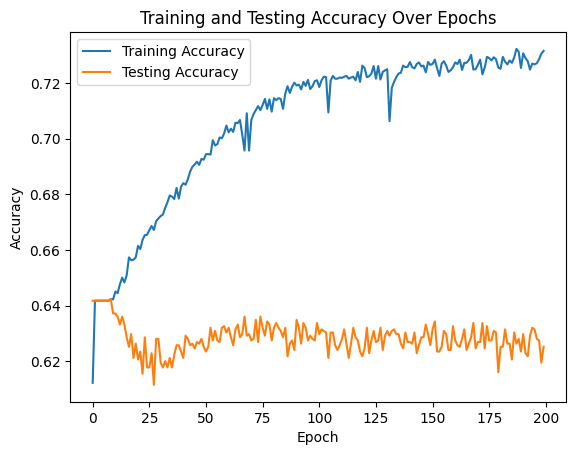

In [52]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Plot the training accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
# Plot the testing accuracy
plt.plot(hist.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()
plt.show()


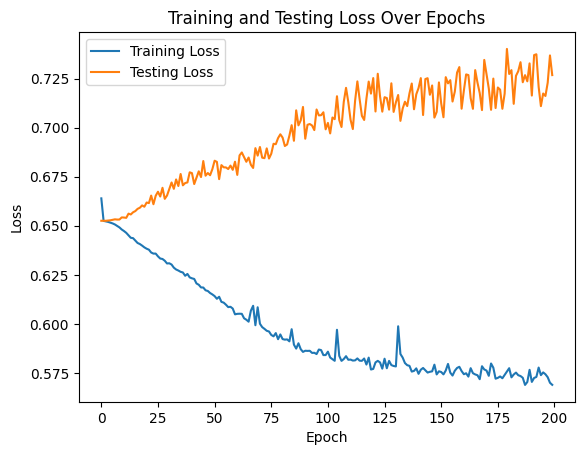

In [53]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(hist.history['loss'], label='Training Loss')
# Plot the testing loss
plt.plot(hist.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()


# SVC model

In [27]:
# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']
print(X.columns)

Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems',
       'Medication Use', 'BMI', 'Triglycerides', 'Systolic Pressure',
       'Diastolic Pressure'],
      dtype='object')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVC
SVC_model = SVC(kernel='linear')
SVC_model.fit(X_train, y_train)

In [ ]:
SVC_predictions = SVC_model.predict(X_test)

In [ ]:
print(f"Training Data Score: {SVC_model.score(X_train, y_train)}")
print(f"Testing Data Score: {SVC_model.score(X_test, y_test)}")

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, SVC_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, SVC_predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  SVC_predictions))
